In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as sma
import pmdarima
import datetime
import matplotlib
import pytest

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt, exp

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

sns.set_style('whitegrid')

import sys
sys.path.append('..')
from src.data.dataset_generator import DatasetGenerator
from src.data.data_transformer import DataTransformer

# 1. Reading in the Data from the API

Download the Data (Montel Data & Entsoe & Weather Data)

In [3]:
dg = DatasetGenerator(['all'])
dataset_latest = dg.get_dataset('2016-01-01', 'latest', 'ignored')

Repaired missing entsoe data from dates: ['2021-08-13']
Data coverage 100%
Data coverage 100%


# 2. Data Preprocessing

Set datetime as index of the dataframe and display the length and timerange of the downloaded dataset.

In [4]:
# Extract Length, and Timerange of the Downloaded Dataset
X = dataset_latest.Time

datapoints = X.index.max()
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))

# Change Index from Dataframe (new index: Time)
data_hourly = dataset_latest.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')

Number of datapoints in the Dataset: 49247
Minimum date from data set: 2016-01-01 00:00:00
Maximum date from data set: 2021-08-13 23:00:00


## 2.1 Display Data Characteristics

In [5]:
data_hourly

,SPOTPrice,Load,Solar,Wind Offshore,Wind Onshore,temp_muc,dwpt_muc,rhum_muc,prcp_muc,wspd_muc,pres_muc,tsun_muc,temp_ham,dwpt_ham,rhum_ham,prcp_ham,wspd_ham,pres_ham,tsun_ham
2016-01-01 00:00:00,23.86,50211.00,0.0,2275.25,6601.25,5.2,4.9,98.0,0.1,1.4,1026.6,0.0,2.4,2.0,97.0,0.0,6.1,1023.4,0.0
2016-01-01 01:00:00,22.39,48192.75,0.0,2285.50,6445.75,4.7,4.6,99.0,0.0,3.2,1026.4,0.0,2.0,2.0,100.0,0.0,9.4,1023.5,0.0
2016-01-01 02:00:00,20.59,46264.75,0.0,2228.75,6422.75,3.8,3.7,99.0,0.5,4.3,1026.9,0.0,2.0,2.0,100.0,0.0,9.4,1023.4,0.0
2016-01-01 03:00:00,16.81,44942.00,0.0,2011.50,6487.00,4.0,3.9,99.0,0.5,4.0,1027.4,0.0,1.4,1.0,97.0,0.0,9.7,1023.4,0.0
2016-01-01 04:00:00,17.41,44431.50,0.0,1942.75,6391.25,4.0,3.9,99.0,0.6,4.0,1027.5,0.0,1.0,0.6,97.0,0.0,7.6,1023.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-13 19:00:00,117.48,64650.25,30330.0,392.00,1463.00,29.0,16.2,46.0,0.0,13.0,1020.0,0.0,24.3,15.2,57.0,0.0,16.7,1019.2,0.0
2021-08-13 20:00:00,115.68,64650.25,30330.0,392.00,1463.00,29.0,16.2,46.0,0.0,13.0,1020.0,0.0,24.3,15.2,57.0,0.0,16.7,1019.2,0.0
2021-08-13 21:00:00,115.77,64650.25,30330.0,392.00,1463.00,29.0,16.2,46.0,0.0,13.0,1020.0,0.0,24.3,15.2,57.0,0.0,16.7,1019.2,0.0
2021-08-13 22:00:00,106.91,64650.25,30330.0,392.00,1463.00,29.0,16.2,46.0,0.0,13.0,1020.0,0.0,24.3,15.2,57.0,0.0,16.7,1019.2,0.0


In [6]:
data_hourly.describe()

,SPOTPrice,Load,Solar,Wind Offshore,Wind Onshore,temp_muc,dwpt_muc,rhum_muc,prcp_muc,wspd_muc,pres_muc,tsun_muc,temp_ham,dwpt_ham,rhum_ham,prcp_ham,wspd_ham,pres_ham,tsun_ham
count,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000,49248.000000
mean,38.034908,60917.548611,4803.814378,2288.896559,10366.867512,10.767063,5.185331,71.624574,0.112128,10.105425,1017.338014,13.645458,10.371623,6.311600,78.321272,0.083142,14.685601,1015.042152,11.777098
std,19.800550,11621.758924,7333.200559,1693.522030,8295.119443,8.277277,6.633945,18.350747,0.662849,5.640885,8.620478,22.778382,7.348837,6.109083,16.463817,0.496798,7.936602,10.105408,21.053090
min,-130.090000,0.000000,0.000000,0.000000,0.000000,-13.900000,-17.500000,15.000000,0.000000,0.000000,982.000000,0.000000,-13.800000,-19.000000,18.000000,0.000000,0.000000,973.500000,0.000000
25%,27.160000,51795.250000,0.000000,772.187500,4057.500000,4.300000,0.000000,58.000000,0.000000,6.100000,1012.300000,0.000000,5.000000,2.000000,68.000000,0.000000,9.400000,1009.100000,0.000000
50%,36.300000,60381.750000,173.625000,2054.875000,7912.875000,10.500000,5.000000,76.000000,0.000000,8.600000,1017.400000,0.000000,10.000000,6.300000,82.000000,0.000000,13.300000,1015.700000,0.000000
75%,47.740000,70088.062500,7730.375000,3550.312500,14323.875000,16.900000,11.000000,87.000000,0.000000,12.600000,1022.400000,22.000000,15.900000,11.100000,93.000000,0.000000,19.400000,1021.500000,14.000000
max,200.040000,90809.500000,36175.250000,7126.250000,40987.250000,35.800000,20.700000,100.000000,37.500000,49.000000,1047.100000,60.000000,35.000000,21.600000,100.000000,38.700000,63.000000,1046.200000,60.000000


## 2.3 Extract each Feature from the Dataframe

Each Feature of the Dataframe is extracted as Pandas Series

In [7]:
data_spot = data_hourly.SPOTPrice
data_temp = data_hourly.temp_muc
data_dwpt = data_hourly.dwpt_muc
data_rhum = data_hourly.rhum_muc
data_prcp = data_hourly.prcp_muc
data_wspd = data_hourly.wspd_muc
data_pres = data_hourly.pres_muc
data_tsun = data_hourly.tsun_muc

## 2.4 Create Spotprice Datasets with different length (Final Week excluded)

For testing univariant spot price forecasting, subdivide the whole dataset into datasets with the following lengths \
(final week is excluded for the model evaluation; will be changed for a better quality in evaluation):
* previous 5 and 1 year/-s
* previous 6, 3 and 1 month/-s
* previous 3, 2 and 1 week/-s
* previous 5, 4, 3, 2 and 1 day/-s

In [8]:
# Testing set for Walk Forward Evaluation (+1h and +24h)
df_test = data_spot.iloc[-169:]
# Training and Validation Sets for Model Training and Hyperparameter Tuning
df_all = data_spot.iloc[:-169]
df_5a = data_spot.iloc[38568:-169]
df_1a = data_spot.iloc[73632:-169]
df_6m = data_spot.iloc[-4512:-169]
df_3m = data_spot.iloc[-2304:-169]
df_1m = data_spot.iloc[-912:-169]
df_3w = data_spot.iloc[-672:-169]
df_2w = data_spot.iloc[-504:-169]
df_1w = data_spot.iloc[-336:-169]
df_5d = data_spot.iloc[-288:-169]
df_4d = data_spot.iloc[-264:-169]
df_3d = data_spot.iloc[-240:-169]
df_2d = data_spot.iloc[-216:-169]
df_1d = data_spot.iloc[-192:-169]

## 2.5 Create Mean Spotprice Datasets with different Means (Daily, Weekly, Monthly)

In [9]:
data_daily = data_spot.resample('1D').mean()

data_weekly = data_spot.resample('1W').mean()

data_monthly = data_spot.resample('1M').mean()

# 3. Data Visualization

## 3.1 Seasonal Decomposition

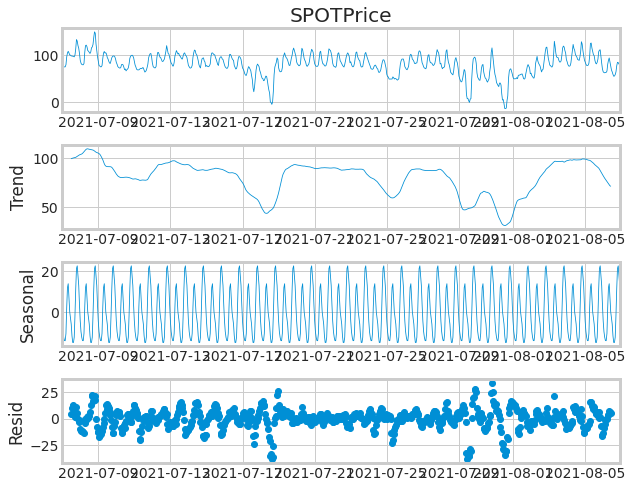

In [10]:
mpl.rcParams['figure.figsize'] = 9, 7
mpl.rcParams['lines.linewidth'] = 0.8
decomposition = seasonal_decompose(df_1m, period=24)
fig = decomposition.plot()
plt.show()

## 3.2 ACF & PACF

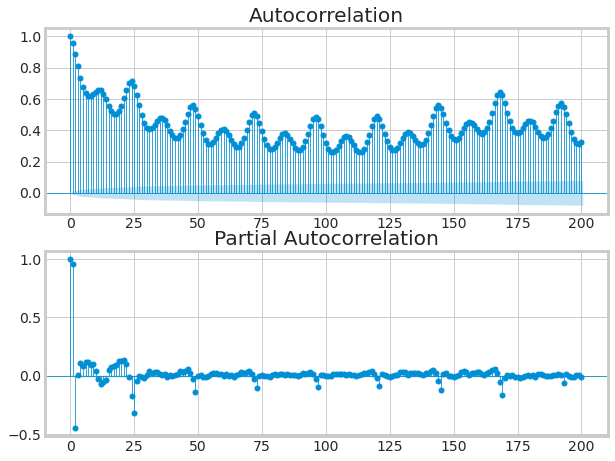

In [11]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(data_spot, lags=200, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(data_spot, lags=200, ax=ax[1])
plt.show()

## 3.3 Plot Data

### 3.3.1 Plot Mean Data

Text(0.5, 1.0, 'EEX Day-Ahead Market')

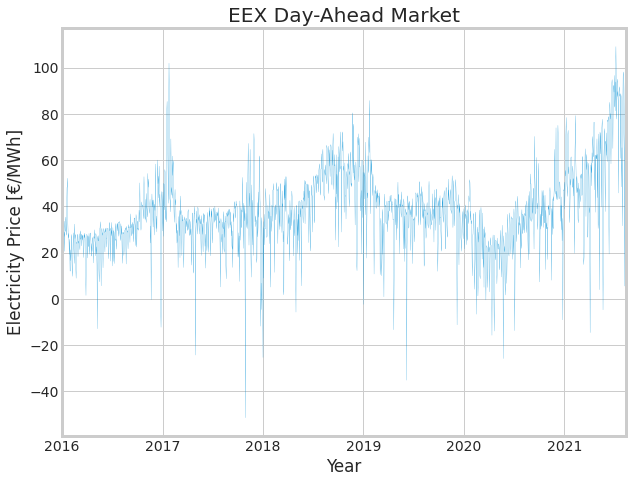

In [12]:
ax = data_daily.plot(linewidth=0.2)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

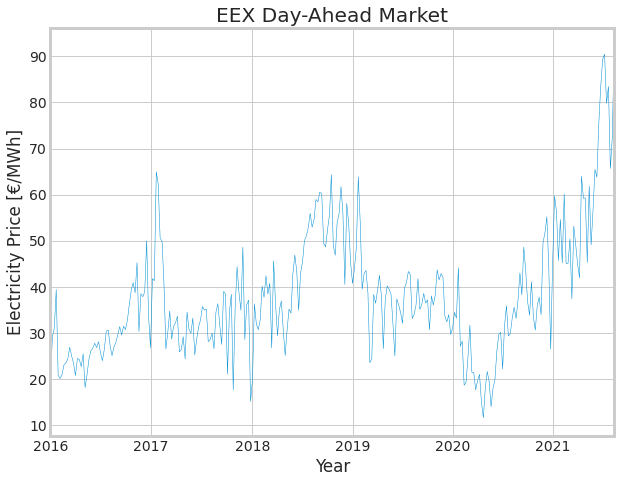

In [13]:
ax = data_weekly.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

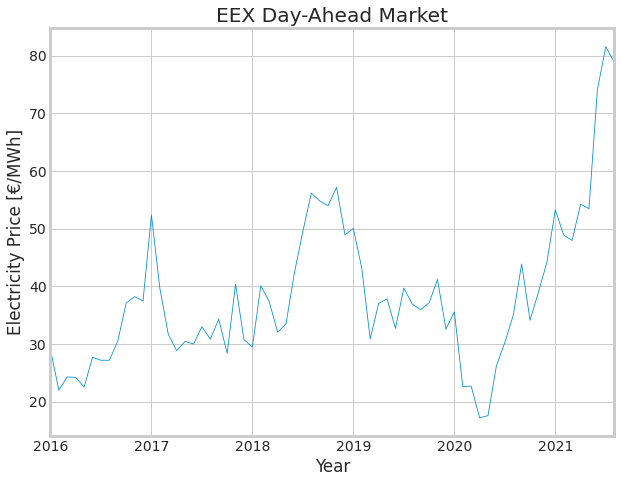

In [14]:
ax = data_monthly.plot(linewidth=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

### 3.3.2 Plot Hourly Data

Text(0.5, 1.0, 'EEX Day-Ahead Market')

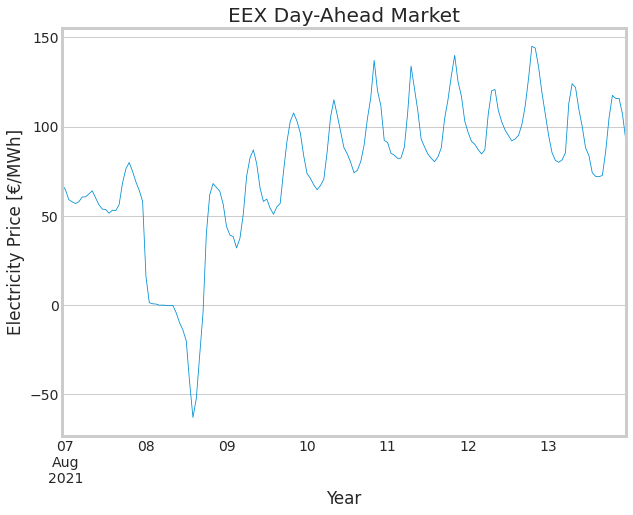

In [15]:
# The data of the last week is used as the test set for the Statistical Models
ax = df_test.plot(linewidth=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

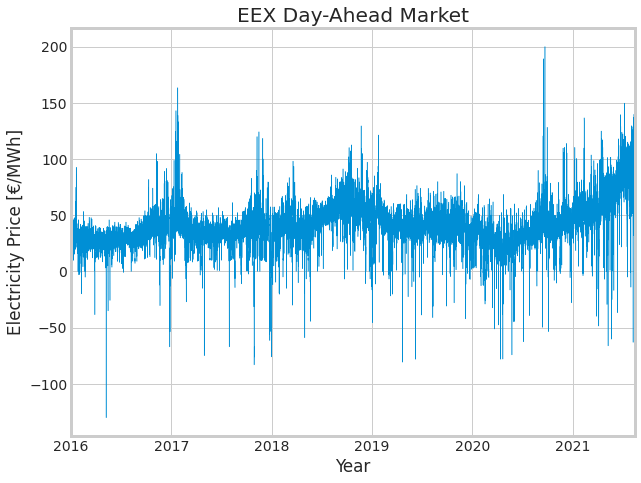

In [16]:
# Whole dataset
ax = data_spot.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

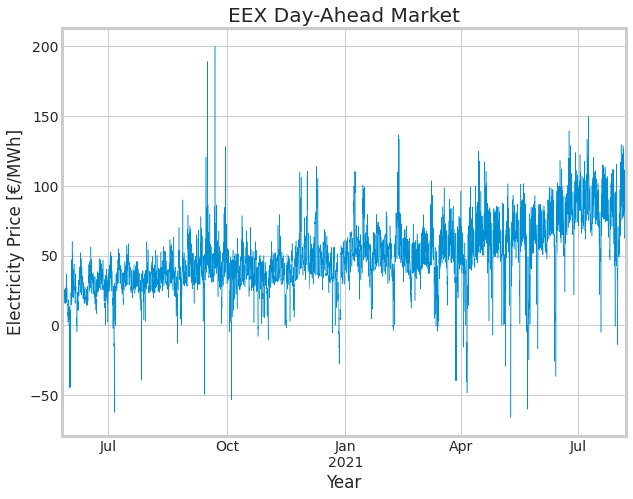

In [17]:
# Previous 5 years
ax = df_5a.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

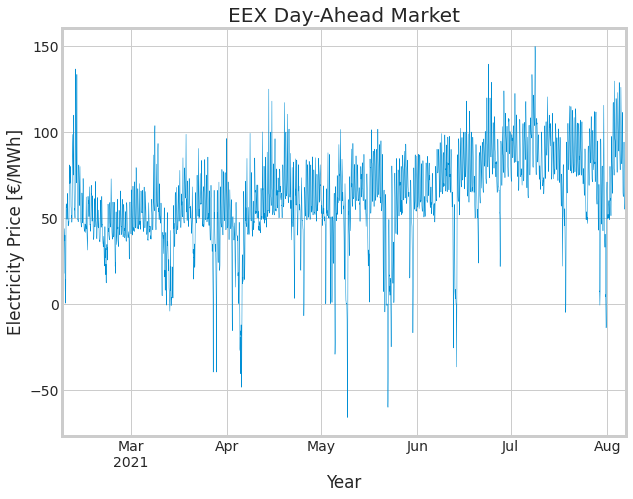

In [18]:
# Previous year
ax = df_6m.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

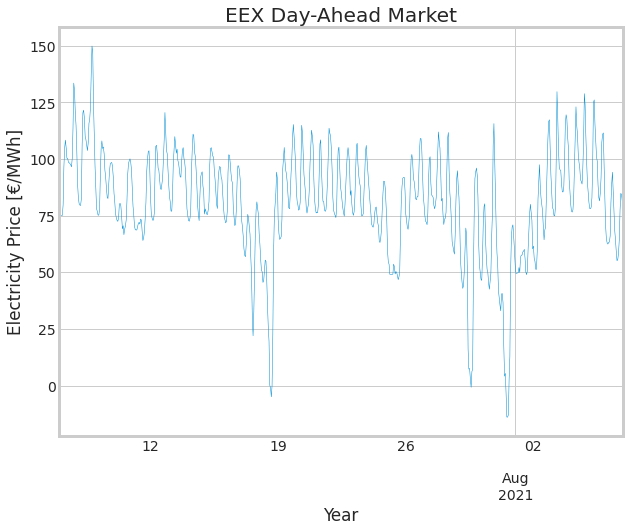

In [19]:
# Previous one month
ax = df_1m.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

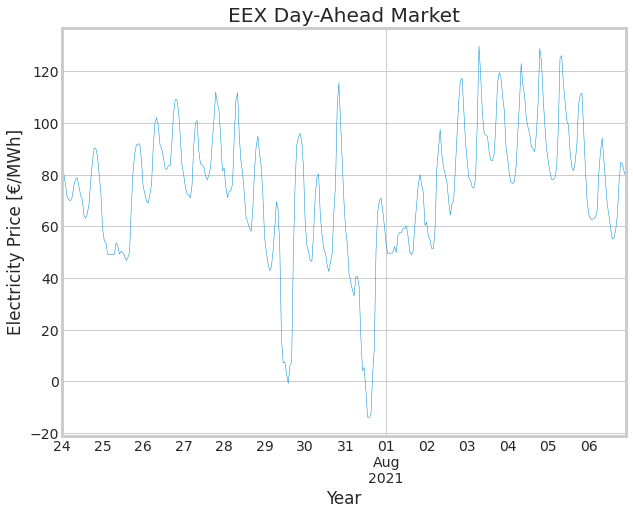

In [20]:
# Previous 2 weeks
ax = df_2w.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

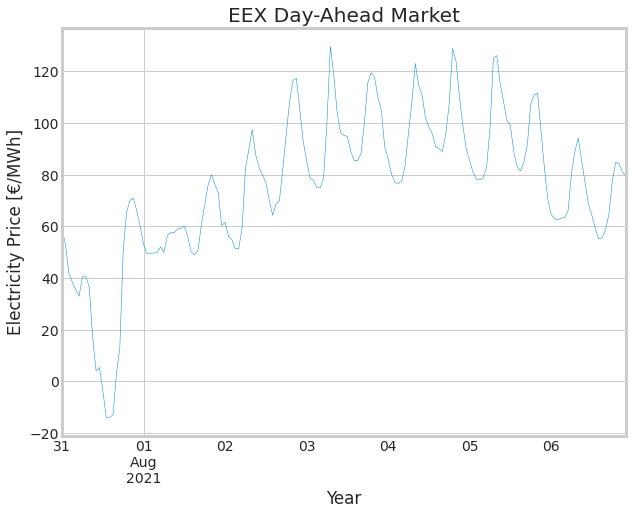

In [21]:
# Previous week
ax = df_1w.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

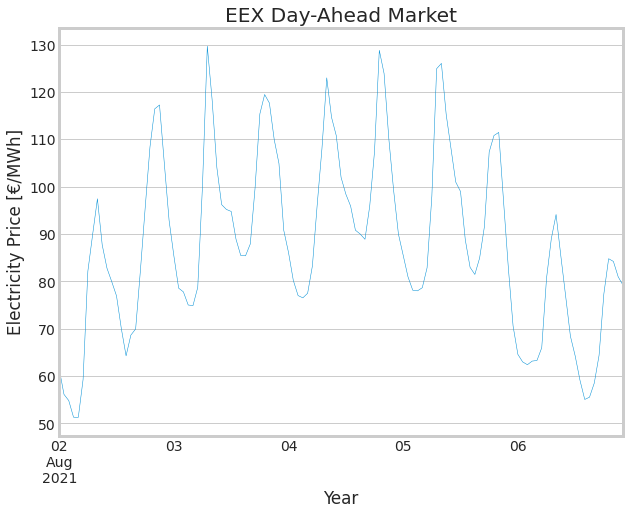

In [22]:
# Previous 5 days
ax = df_5d.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

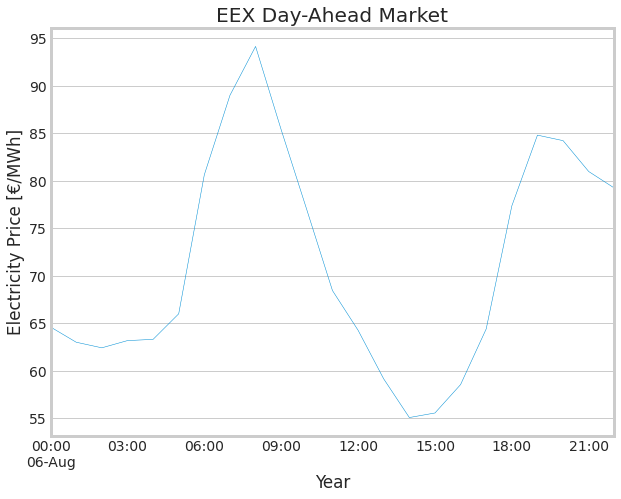

In [23]:
# Previous day
ax = df_1d.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

# 4. Tests for Stationarity, Seasonality and other Characteristics for TSF

## 4.1 Augmented Dickey-Fuller (ADF) test

In [24]:
nonst_test = sma.adfuller(data_spot)

output = pd.Series(nonst_test[0:4], index=['t-statistic','p-value','lags-used','no-of-observations'])
for key,value in nonst_test[4].items():
    output['Critical Value (%s)'%key] = value
    
print(output)

t-statistic            -1.350226e+01
p-value                 2.961250e-25
lags-used               5.700000e+01
no-of-observations      4.919000e+04
Critical Value (1%)    -3.430483e+00
Critical Value (5%)    -2.861599e+00
Critical Value (10%)   -2.566801e+00
dtype: float64


t-statistic               -33.528643
p-value                     0.000000
lags-used                  55.000000
no-of-observations      46531.000000
Critical Value (1%)        -3.430491
Critical Value (5%)        -2.861602
Critical Value (10%)       -2.566803
dtype: float64


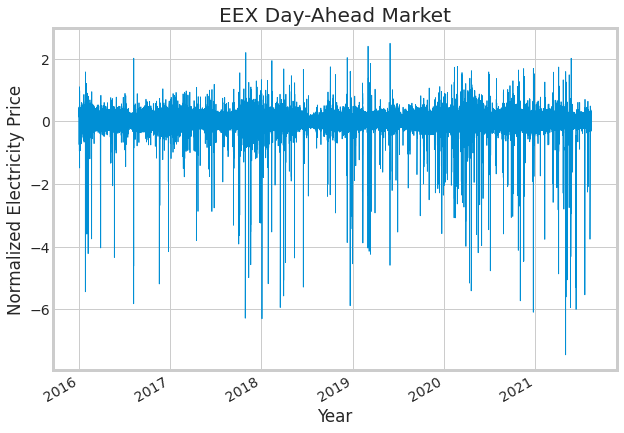

In [25]:
log_data = np.log(data_spot) # Taking the log
ma_data = log_data.rolling(window=12).mean() # Taking moving average
log_minus_ma_data = log_data - ma_data
log_minus_ma_data.dropna(inplace=True)

ax = log_minus_ma_data.plot(linewidth = 0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Electricity Price')
ax.set_title('EEX Day-Ahead Market')

st_test = sma.adfuller(log_minus_ma_data)

output = pd.Series(st_test[0:4], index=['t-statistic','p-value','lags-used','no-of-observations'])
for key,value in st_test[4].items():
    output['Critical Value (%s)'%key] = value
    
print(output)

## 4.2 PP test

In [26]:
test = pmdarima.arima.PPTest()
test.should_diff(data_spot)

(0.01, False)

In [27]:
test.should_diff(log_minus_ma_data)

(0.01, False)

## 4.3 CH Test (Test for seasonal differences)

In [28]:
results = pmdarima.arima.CHTest(m=24).estimate_seasonal_differencing_term(data_spot)
print(results)

1


## 4.4 OCSB Test (Test for Seasonal differencing D)

In [29]:
results = pmdarima.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(data_spot)
print(results)

0
